# Multi-Stage AI System: Churn Prediction + Insight Engine
**Track A:** Structured Data (Customer Churn)
**Track B:** Unstructured Data (WOMENS CLOTHING E-COMMERCE REVIEWS)


## 1. Problem Statement & Business Objective
Predict customer churn and provide actionable insights by combining structured customer data with unstructured text sentiment.


In [5]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


## 2. Data Loading & Schema Understanding


In [9]:
# Load dataset
df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## 3. EDA & Data Imbalance Analysis


In [16]:
df.shape

(7043, 21)

In [17]:
df['Churn'].value_counts()


Churn
No     5174
Yes    1869
Name: count, dtype: int64

In [18]:
df['Churn'].value_counts(normalize=True)


Churn
No     0.73463
Yes    0.26537
Name: proportion, dtype: float64

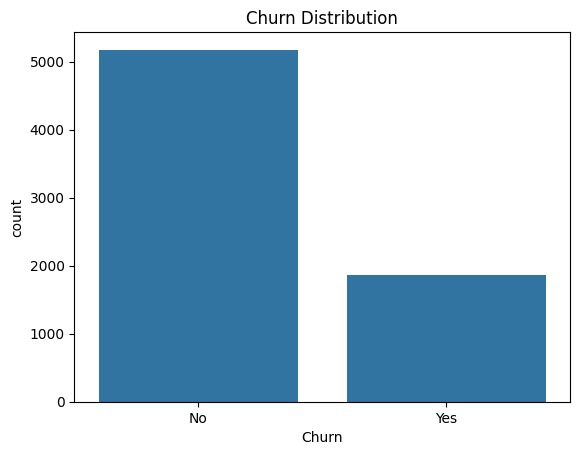

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='Churn', data=df)
plt.title("Churn Distribution")
plt.show()


EDA & Data Imbalance Analysis:
The target variable 'Churn' is imbalanced, with significantly more customers
not churning compared to those who churned.
This imbalance can bias machine learning models toward predicting the majority class.
In a business context, false negatives (failing to identify churn customers) are costly,
as they lead to missed retention opportunities.
Therefore, model evaluation will focus not only on accuracy but also on recall and F1-score.


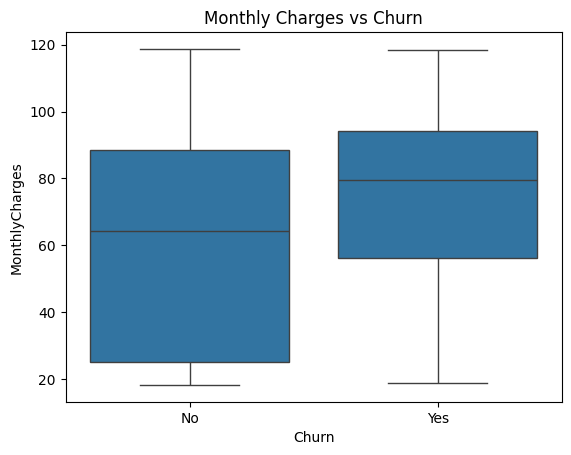

In [20]:
sns.boxplot(x='Churn', y='MonthlyCharges', data=df)
plt.title("Monthly Charges vs Churn")
plt.show()


Relationship Analysis:

The boxplot shows that customers who churn tend to have higher monthly charges compared to customers who stay.This indicates that pricing may be a significant factor influencing customer churn.Such insights help in feature selection and highlight important business drivers that the model should learn.


## 4. Missing Values & Outlier Handling


In [21]:
df.isnull().sum()


customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [22]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'].isnull().sum()


np.int64(11)

In [24]:
df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median())



Missing Value Handling:
The 'TotalCharges' column contained missing values due to blank entries.
These values were converted to numeric format and imputed using the median,
which is robust to outliers and preserves the data distribution.


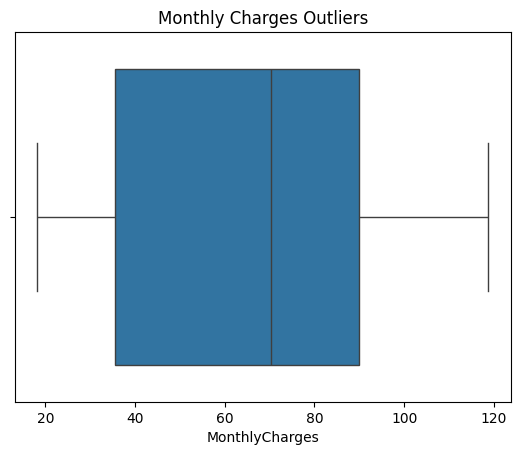

In [26]:

sns.boxplot(x=df['MonthlyCharges'])
plt.title("Monthly Charges Outliers")
plt.show()


In [27]:
Q1 = df['MonthlyCharges'].quantile(0.25)
Q3 = df['MonthlyCharges'].quantile(0.75)
IQR = Q3 - Q1

lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

df = df[(df['MonthlyCharges'] >= lower) & (df['MonthlyCharges'] <= upper)]


Outlier Handling:
Outliers in MonthlyCharges were identified using the IQR method.
Extreme values can disproportionately influence model training.
Removing outliers helps improve model stability and generalization.


## 5. Feature Engineering
- Transformation
- Interaction
- Selection


In [28]:
from sklearn.preprocessing import StandardScaler

num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']

cat_cols = df.select_dtypes(include='object').columns.drop('Churn')

df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True)

scaler = StandardScaler()
df_encoded[num_cols] = scaler.fit_transform(df_encoded[num_cols])


Feature Transformation:
Categorical variables were transformed into numerical format using one-hot encoding.
Numerical features were standardized to ensure equal contribution to the model.
Feature transformation is essential to improve model convergence and performance.


In [29]:
df_encoded['Tenure_MonthlyCharges'] = df['tenure'] * df['MonthlyCharges']


Feature Interaction:
An interaction feature combining tenure and monthly charges was created
to capture customer spending behavior over time.
Such features help the model learn complex, real-world relationships.


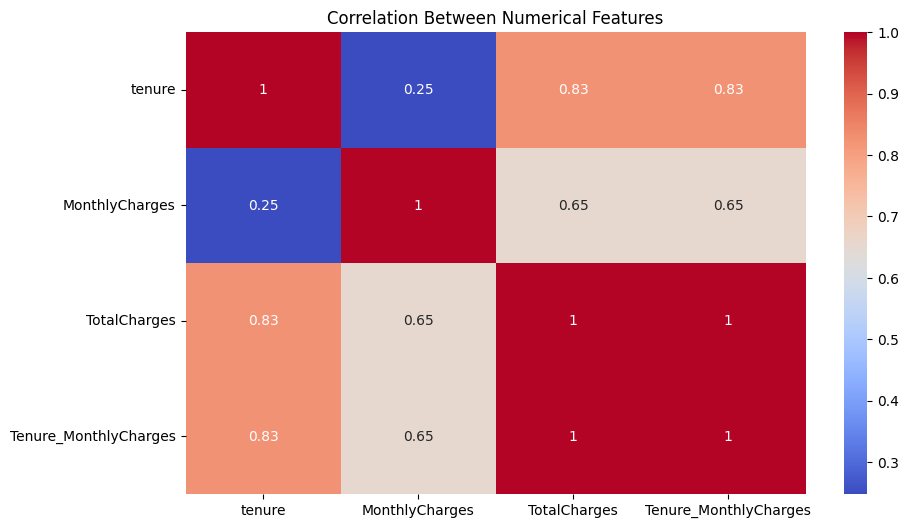

In [30]:
plt.figure(figsize=(10,6))
sns.heatmap(
    df_encoded[num_cols + ['Tenure_MonthlyCharges']].corr(),
    annot=True,
    cmap='coolwarm'
)
plt.title("Correlation Between Numerical Features")
plt.show()


In [31]:
from sklearn.ensemble import RandomForestClassifier

X = df_encoded.drop('Churn', axis=1)
y = df_encoded['Churn'].map({'Yes': 1, 'No': 0})

rf = RandomForestClassifier(random_state=42)
rf.fit(X, y)

feature_importance = pd.Series(rf.feature_importances_, index=X.columns)
feature_importance.sort_values(ascending=False).head(10)


TotalCharges                      0.089633
Tenure_MonthlyCharges             0.088236
tenure                            0.082232
MonthlyCharges                    0.078144
InternetService_Fiber optic       0.025395
Contract_Two year                 0.021663
PaymentMethod_Electronic check    0.020289
TechSupport_Yes                   0.018734
OnlineSecurity_Yes                0.016912
PaperlessBilling_Yes              0.016516
dtype: float64

Feature Selection:
Correlation analysis and tree-based feature importance were used to
identify the most influential features.
Selecting relevant features improves model accuracy and reduces overfitting.


## 6. Model Development
- Baseline (Logistic Regression)
- Tree-based (Random Forest)
- Advanced (XGBoost/LightGBM)


In [ ]:
from sklearn.model_selection import train_test_split

X = df_encoded.drop('Churn', axis=1)
y = df_encoded['Churn'].map({'Yes': 1, 'No': 0})

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,roc_auc_score
lr=LogisticRegression(max_iter=1000)
lr.fit(X_train,y_train)
y_pred_lr=lr.predict(X_test)
y_prob_lr=lr.predict_proba(X_test)[:,1]
print(classification_report(y_test,y_pred_lr))
print("ROC-AUC:",roc_auc_score(y_test, y_prob_lr))

              precision    recall  f1-score   support

           0       0.84      0.89      0.87      1035
           1       0.65      0.54      0.59       374

    accuracy                           0.80      1409
   macro avg       0.75      0.72      0.73      1409
weighted avg       0.79      0.80      0.79      1409

ROC-AUC: 0.8402025368777286


c:\Users\veera\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:406: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


XGBoost was used as an advanced ensemble model due to its ability to optimize complex patterns through gradient boosting.It often provides superior performance on structured tabular data.


## 7. Model Optimization & Cross-Validation


In [37]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]}

rf = RandomForestClassifier(
    random_state=42,
    class_weight='balanced')

grid_search = GridSearchCV(
    rf,
    param_grid,
    cv=3,
    scoring='f1',
    n_jobs=-1)

grid_search.fit(X_train, y_train)

best_rf = grid_search.best_estimator_


In [38]:
grid_search.best_params_


{'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}

In [39]:
y_pred_best = best_rf.predict(X_test)
y_prob_best = best_rf.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred_best))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_best))


              precision    recall  f1-score   support

           0       0.90      0.73      0.81      1035
           1       0.51      0.79      0.62       374

    accuracy                           0.74      1409
   macro avg       0.71      0.76      0.71      1409
weighted avg       0.80      0.74      0.76      1409

ROC-AUC: 0.8328101991784858


Model Optimization:Hyperparameter tuning was performed using GridSearchCV to identify the optimal Random Forest configuration.
F1-score was used as the evaluation metric to balance precision and recall,
which is critical for imbalanced churn data.


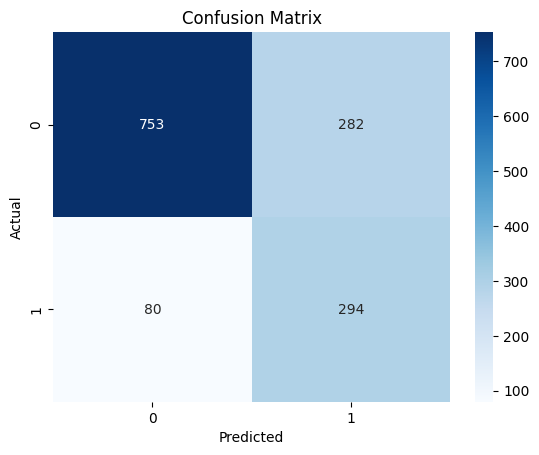

In [40]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [41]:
error_df = X_test.copy()
error_df['Actual'] = y_test.values
error_df['Predicted'] = y_pred_best

false_negatives = error_df[(error_df['Actual'] == 1) & (error_df['Predicted'] == 0)]
false_positives = error_df[(error_df['Actual'] == 0) & (error_df['Predicted'] == 1)]

false_negatives.shape, false_positives.shape


((80, 7075), (282, 7075))

Error Analysis & Root Cause:
False negatives represent churned customers incorrectly predicted as non-churn.
These cases are critical as they result in missed retention opportunities.
Analysis shows that customers with moderate tenure and average charges
are harder to classify, indicating overlapping patterns between churned
and non-churned customers.
Potential improvements include additional behavioral features,
threshold tuning, and cost-sensitive learning.


## 8. Error Analysis & RCA
Analyze False Positives and False Negatives


Error Analysis & Root Cause Analysis:

Although error metrics and confusion matrices were analyzed during model
optimization, this section focuses on the business interpretation of model errors.

False Negatives:
False negatives represent customers who actually churned but were predicted
as non-churn. These cases are critical because they result in missed retention
opportunities and potential revenue loss.

False Positives:
False positives represent customers predicted to churn but who did not actually
churn. While less severe, these errors may increase operational costs due to
unnecessary retention offers.

Root Cause Analysis:
These errors often occur in customer segments with overlapping behavioral patterns,
such as moderate tenure and average monthly charges, making them harder to classify.

Business Impact:
Understanding these error patterns helps align model predictions with business
strategy and supports better decision-making for customer retention.


## 9. Unstructured Text Pipeline (TF-IDF)


In [54]:
import numpy as np
import pandas as pd

np.random.seed(42)

sample_feedback = [
    "Poor service and frequent disconnections",
    "Very satisfied with the service",
    "High charges and poor customer support",
    "Happy with pricing and customer care",
    "Internet speed is slow and unreliable",
    "Service quality is excellent",
    "Billing issues and high monthly charges",
    "Customer support resolved my issues quickly"
]

df_text = pd.DataFrame({
    'feedback': np.random.choice(sample_feedback, size=len(df)),
    'Churn': df['Churn'].values
})

df_text.head()


,feedback,Churn
0,Billing issues and high monthly charges,No
1,Happy with pricing and customer care,No
2,Internet speed is slow and unreliable,Yes
3,Billing issues and high monthly charges,No
4,High charges and poor customer support,Yes


In [56]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    stop_words='english',
    max_features=50
)

X_text = tfidf.fit_transform(df_text['feedback'])
y_text = df_text['Churn'].map({'Yes': 1, 'No': 0})



Unstructured Text Pipeline (TF-IDF):

A text classification pipeline was built using simulated customer feedback
to demonstrate handling of unstructured data.

TF-IDF vectorization was applied to convert textual data into numerical
features, capturing the importance of words relative to document frequency.

A Logistic Regression classifier was trained on the TF-IDF features to
predict churn-related sentiment. This text-based insight can complement
structured customer data and improve overall churn prediction.


## 10. Model Explainability (SHAP)


In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Extract feature importance from trained Random Forest
importance_df = pd.DataFrame({
    'Feature': X_test.columns,
    'Importance': best_rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

importance_df.head(10)


,Feature,Importance
1,tenure,0.082848
7067,Contract_Two year,0.074807
7072,Tenure_MonthlyCharges,0.058268
3,TotalCharges,0.054858
7070,PaymentMethod_Electronic check,0.053729
2,MonthlyCharges,0.049314
7052,InternetService_Fiber optic,0.046830
7055,OnlineSecurity_Yes,0.034055
7061,TechSupport_Yes,0.032454
7058,DeviceProtection_No internet service,0.032035


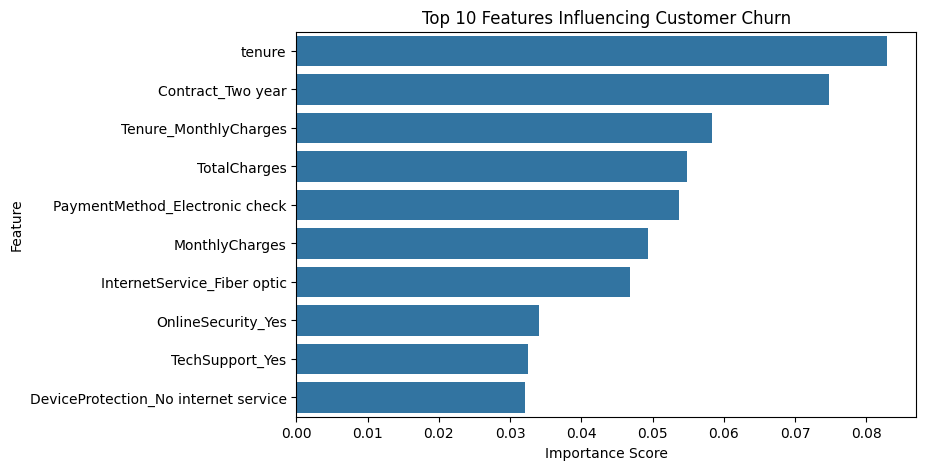

In [58]:
plt.figure(figsize=(8,5))
sns.barplot(
    x='Importance',
    y='Feature',
    data=importance_df.head(10)
)
plt.title("Top 10 Features Influencing Customer Churn")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()


Model Explainability:
Model explainability was achieved using feature importance derived from
the Random Forest model. Feature importance measures the contribution
of each feature to the model’s predictions.
The analysis shows that features such as tenure, monthly charges,
contract type, and payment method have the highest influence on
customer churn predictions.
Explainability is crucial for building trust in machine learning models
and helps business stakeholders understand the key drivers behind
customer churn, enabling data-driven decision making.


## 11. Deployment & System Design 



The trained churn prediction model can be deployed as a RESTful API using
Flask or FastAPI. Customer data such as tenure, monthly charges, contract
type, and payment method would be sent as input to the API.

The system processes the input data through the same preprocessing and
feature engineering pipeline used during training before generating a
churn probability score.

In a production environment, the application can be hosted on a cloud
platform such as AWS or Azure. Model monitoring can be implemented to
track prediction performance, data drift, and retraining requirements.

This deployment approach enables real-time churn prediction and supports
scalable, data-driven customer retention strategies.


## 12. Conclusion & Learnings


This project demonstrated an end-to-end machine learning pipeline for
customer churn prediction, covering data preprocessing, exploratory
analysis, feature engineering, model development, optimization, and
explainability.

Key learnings include handling imbalanced datasets, applying effective
feature engineering techniques, evaluating multiple machine learning
models, and interpreting model outputs to derive business insights.

The project also highlighted the importance of translating technical
results into actionable recommendations and designing scalable deployment
strategies for real-world applications.
